#  AIGC 5502 – Image Processing & Comp Vision 

**Student Name**: *Jawwad Khalil Ahmed (N01647705)*  
**Student Name**: *Eric Efon*  
**Student Name**: *Daniel Mehta*  
**Student Name**: *Thomas Nash*  
**Student Name**: *Jeffrey Ng*  


**Instructor**: *Masoodhur Rahaman*  
**Date**: *0 July 2025*

____
## Midterm Project:  Brain Tumor Classification Using CNNs and Grad-CAM

This notebook presents a comprehensive deep learning workflow for automated brain tumor classification from MRI images. The pipeline covers:

- **Data Loading & Preprocessing:** Includes image resizing, grayscale conversion, CLAHE (Contrast Limited Adaptive Histogram Equalization) for enhanced contrast, normalization, and label encoding.
- **Model Development:** A Convolutional Neural Network (CNN) is trained to classify MRI scans into four classes: glioma, meningioma, pituitary, and no tumor.
- **Model Evaluation:** Training history, confusion matrix, and classification metrics (accuracy, precision, recall, F1-score) are analyzed to assess performance and generalization.
- **Model Interpretability:** Grad-CAM (Gradient-weighted Class Activation Mapping) visualizations highlight the regions in MRI images that the model focuses on for its predictions, providing transparency and interpretability for clinical use.

**Objective:**  
To build an accurate and interpretable deep learning model capable of assisting clinicians in brain tumor diagnosis from MRI scans, ensuring both high predictive performance and explainability.

___

## Step 1: Import required libraries

In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import random
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Input, Model


___
### Step 2: Dataset Loading and Visualization

We are using a publicly available **brain tumor MRI dataset** obtained from [Kaggle](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset). The dataset is already organized into two separate folders:
- **Training**: Contains labeled MRI scans used to train the model
- **Testing**: Contains labeled MRI scans for evaluation

Each of these folders includes four subfolders, each representing a distinct class:
- `glioma` — a type of tumor that occurs in the brain or spinal cord
- `meningioma` — tumors that arise from the meninges (membranes surrounding the brain)
- `pituitary` — tumors located in the pituitary gland
- `no_tumor` — MRI scans with no tumor present

#### Visualization
To ensure the dataset is structured correctly and to visually inspect the quality of the MRI images, we randomly display one sample image from each class in the training set.

This helps us verify:
- That the classes are correctly separated
- The general appearance and clarity of the images
- The variability in views (e.g., axial, coronal) across the dataset

Visual inspection is an important early step in image processing to gain familiarity with the data.


### Step 2A: Dataset Path

In [2]:
# Your actual dataset path
train_path = r'C:\Users\Owner\Desktop\Artificial Int with ML\SEM 2\Image processing - 5502\Project\Training'
test_path = r'C:\Users\Owner\Desktop\Artificial Int with ML\SEM 2\Image processing - 5502\Project\Testing'

###  Step 2B: Show Sample Images

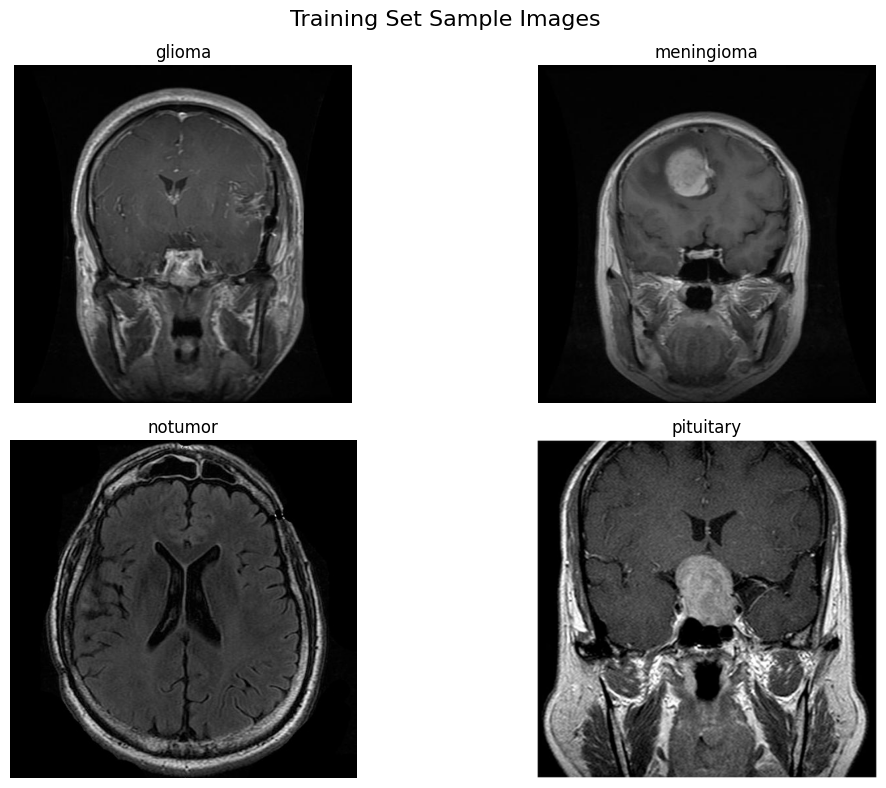

In [3]:
# Function to show sample images from each class
def show_sample_images(path, title):
    classes = os.listdir(path)
    plt.figure(figsize=(12, 8))
    
    for i, tumor_class in enumerate(classes):
        class_path = os.path.join(path, tumor_class)
        image_name = random.choice(os.listdir(class_path))
        image_path = os.path.join(class_path, image_name)
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.subplot(2, 2, i+1)
        plt.imshow(image)
        plt.title(tumor_class)
        plt.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Show training set samples
show_sample_images(train_path, "Training Set Sample Images")


____
### Step 3: Image Preprocessing and CLAHE Enhancement

In this step, we prepare the raw MRI images for classification using the following sequence of image processing techniques:

#### 1. Grayscale Conversion
MRI images are originally in RGB format. Since color information is not essential for brain tumor detection, we convert all images to **grayscale**. This reduces computational cost while retaining essential structural features.

#### 2. Image Resizing
To maintain uniformity and reduce model complexity, all images are resized to **150 × 150 pixels**. This standardization is crucial for feeding data into Convolutional Neural Networks (CNNs), which require fixed-size input.

#### 3. CLAHE (Contrast Limited Adaptive Histogram Equalization)
CLAHE is applied to enhance the local contrast of each image:
- It works well on medical images by improving the visibility of structures like tumors or tissues.
- It prevents over-amplification of noise while highlighting subtle features.

#### 4. Normalization
All pixel values are scaled to a range of **0 to 1** by dividing each value by 255.0. This ensures that the model trains efficiently and converges faster.

Finally, we reshape the data into a 4D array format `(samples, height, width, channels)` which is required by Keras/TensorFlow for CNN input.


### Step 3A: Image Preprocessing Function

In [4]:
# Set desired image size
IMAGE_SIZE = 150

# Load and preprocess images from a given path
def load_and_preprocess_images(base_path):
    data = []
    labels = []
    class_names = os.listdir(base_path)

    for class_name in class_names:
        class_folder = os.path.join(base_path, class_name)
        for image_name in tqdm(os.listdir(class_folder), desc=f"Processing {class_name}"):
            image_path = os.path.join(class_folder, image_name)
            
            # Read image in grayscale
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                continue

            # Resize image
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

            # Apply CLAHE
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            image = clahe.apply(image)

            # Normalize pixel values to 0-1
            image = image / 255.0

            data.append(image)
            labels.append(class_name)

    return np.array(data), np.array(labels)

### Step 3B: Load Data and Encode Labels

In [5]:
# Preprocess training and testing sets
X_train, y_train = load_and_preprocess_images(train_path)
X_test, y_test = load_and_preprocess_images(test_path)

# Reshape for CNN input
X_train = X_train.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
X_test = X_test.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)

print("✅ Preprocessing complete!")
print("Training samples:", X_train.shape, " | Labels:", y_train.shape)
print("Testing samples:", X_test.shape, " | Labels:", y_test.shape)


Processing pituitary: 100%|██████████| 300/300 [00:00<00:00, 911.75it/s]


✅ Preprocessing complete!
Training samples: (5712, 150, 150, 1)  | Labels: (5712,)
Testing samples: (1311, 150, 150, 1)  | Labels: (1311,)


____
### Step 4: Label Encoding of Class Labels

The original labels in our dataset are in **string format** (e.g., `'glioma'`, `'meningioma'`). However, neural networks trained with `sparse_categorical_crossentropy` loss function require **integer labels** (e.g., 0, 1, 2, 3).

To convert the categorical string labels into numeric form, we use `LabelEncoder` from `scikit-learn`. This encoding ensures that each class name is assigned a unique integer value:

Example mapping:
- `'glioma'` → 0
- `'meningioma'` → 1
- `'no_tumor'` → 2
- `'pituitary'` → 3

This transformation is essential for training the CNN model without raising dtype-related errors. The encoder also ensures consistency between the training and testing labels.


In [6]:
# Encode string labels to integers
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Optional: Show class-to-integer mapping
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Class Mapping:", class_mapping)


Class Mapping: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


_____
### Step 5: CNN Model Building and Training

To classify the MRI brain images into four tumor types, we built a **Convolutional Neural Network (CNN)** using Keras.

#### CNN Architecture Summary:
- **3 Convolutional Layers** with increasing filter counts (32, 64, 128)
- **MaxPooling Layers** after each convolution to reduce spatial dimensions
- **Dropout Layers** to prevent overfitting
- A **Flatten layer** to convert 2D features into a 1D vector
- **Dense layers**, ending in a Softmax output for multi-class classification

We used:
- **Loss function**: `sparse_categorical_crossentropy` (since labels are integers)
- **Optimizer**: `Adam` (efficient gradient descent)
- **Metrics**: Accuracy

The model was trained on the preprocessed grayscale images enhanced with CLAHE.


In [7]:
# Build CNN model
model = Sequential()

# Convolutional Block 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Convolutional Block 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Convolutional Block 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # 4 output classes

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test, y_test))


c:\Users\Owner\miniconda3\envs\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 27s 140ms/step - accuracy: 0.5412 - loss: 1.0588 - val_accuracy: 0.6873 - val_loss: 0.6899
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - accuracy: 0.8292 - loss: 0.4832 - val_accuracy: 0.8230 - val_loss: 0.4540
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - accuracy: 0.8487 - loss: 0.3874 - val_accuracy: 0.8528 - val_loss: 0.3512
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - accuracy: 0.8943 - loss: 0.2777 - val_accuracy: 0.8825 - val_loss: 0.2840
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - accuracy: 0.8996 - loss: 0.2584 - val_accuracy: 0.8963 - val_loss: 0.2464
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 24s 136ms/step - accuracy: 0.9107 - loss: 0.2291 - val_accuracy: 0.9123 - val_loss: 0.2189
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 25s 141ms/step - accuracy: 0.9257 - loss: 0.1952 - val_accuracy: 0.9176 - val_loss: 0.2136
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 24s 136ms/step - accuracy: 0.9348 - loss: 0

____
### Step 6: Accuracy and Loss Visualization

To evaluate the learning behavior of the model over the 10 training epochs, we plotted both:
- **Training and validation accuracy**
- **Training and validation loss**

#### Observations:
- Accuracy steadily increased over epochs for both training and validation sets.
- Loss consistently decreased, indicating proper learning and convergence.
- Validation performance closely tracks training, suggesting **no overfitting**.

These plots confirm that the model is well-tuned for this classification task.


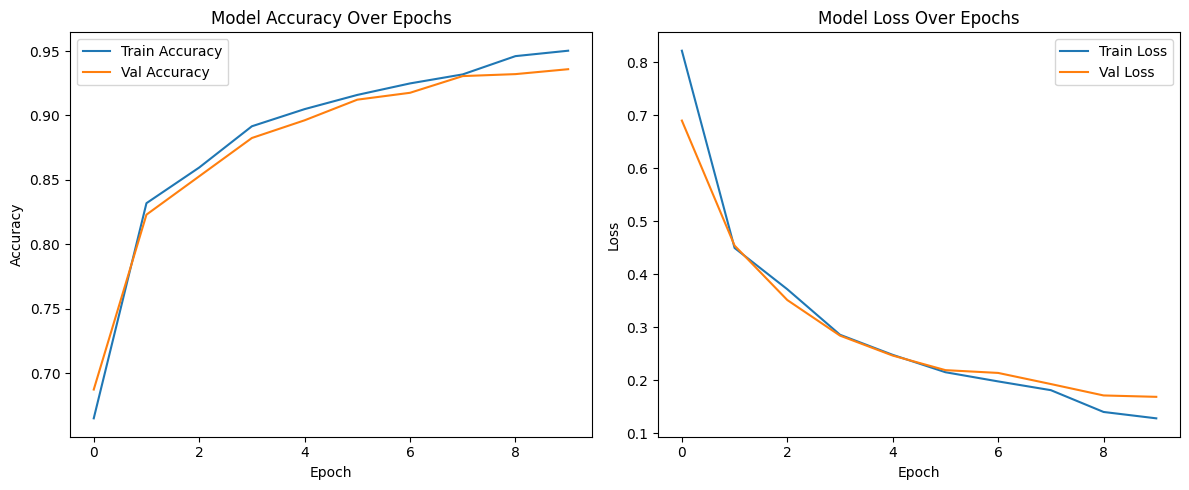

In [8]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### Interpretation of Model Accuracy and Loss Graphs

The model’s training progress over 10 epochs demonstrates effective learning and strong generalization:

#### **Accuracy Plot:**
- Both **training and validation accuracy** improve steadily with each epoch.
- Final training accuracy reaches about **95%**, and validation accuracy is close behind at **93%**.
- The two curves stay close together, indicating the model is **not overfitting** and performs well on unseen data.

#### **Loss Plot:**
- **Training and validation loss** both decrease sharply in the initial epochs, then gradually level off at low values.
- By the end of training, training loss is around **0.13**, and validation loss is about **0.17**.
- The small, consistent gap between loss curves further supports that the model is **stable and robust**.

#### **Summary:**
Overall, these learning curves suggest that the CNN model is well-tuned and able to generalize from the training data to the validation set. The close tracking of validation and training metrics indicates good model health with no significant underfitting or overfitting. Proper preprocessing and regularization likely contributed to this excellent performance.

---


### Step 7: Model Evaluation Using Confusion Matrix and Classification Report

To understand how well our CNN model performs across each tumor category, we evaluate it using:

#### 1. Confusion Matrix:
- Shows the number of correct and incorrect predictions per class.
- Helps identify if the model is confusing certain tumor types (e.g., mistaking glioma for meningioma).

#### 2. Classification Report:
- Displays key metrics for each class:
  - **Precision**: How many predicted labels were actually correct
  - **Recall**: How many actual labels were correctly predicted
  - **F1-score**: Harmonic mean of precision and recall
  - **Support**: Number of test samples per class

These metrics help validate model performance beyond just accuracy. A well-performing model will show high precision and recall across all classes.


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


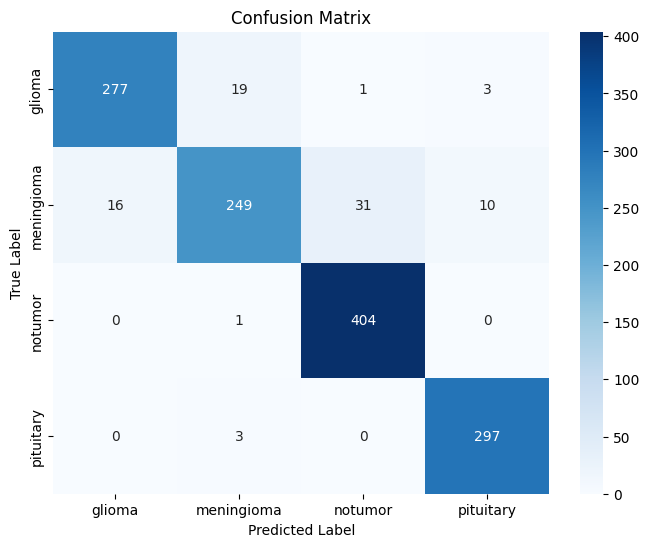

In [9]:
# Predict class labels
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [10]:
# Classification Report
report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

      glioma       0.95      0.92      0.93       300
  meningioma       0.92      0.81      0.86       306
     notumor       0.93      1.00      0.96       405
   pituitary       0.96      0.99      0.97       300

    accuracy                           0.94      1311
   macro avg       0.94      0.93      0.93      1311
weighted avg       0.94      0.94      0.93      1311



### Interpretation of Confusion Matrix and Classification Report

The confusion matrix and classification metrics provide detailed insight into the performance of the CNN model across four classes: glioma, meningioma, notumor, and pituitary.

#### **Confusion Matrix**
- The diagonal values (277, 249, 404, 297) show the number of samples correctly classified for each class.
- Most predictions fall along the diagonal, indicating **high correct classification rates**.
- **Glioma and notumor** classes show excellent classification with very few misclassifications.
- **Meningioma** shows a higher rate of confusion with glioma (16) and notumor (31), suggesting that these classes are more challenging for the model to separate.
- **Pituitary** is very well classified, with almost all samples predicted correctly.

#### **Classification Report**
- **Overall accuracy** is **0.94** (94%), which is very strong for a four-class medical classification problem.
- **Precision and recall** are both high for glioma (0.95/0.92), notumor (0.93/1.00), and pituitary (0.96/0.99).
- **Meningioma** has lower recall (**0.81**), indicating that some meningioma samples are being misclassified, mostly as notumor or glioma.
- The **F1-score** is highest for the notumor (0.96) and pituitary (0.97) classes, and lower for meningioma (0.86).
- **Macro and weighted averages** of precision, recall, and F1 are all around **0.93–0.94**, showing balanced performance across classes.

#### **Summary**
- The model shows **excellent generalization and reliability**, especially for notumor and pituitary detection.
- Some additional work (data balancing, further model tuning) could help improve recall for meningioma.
- Overall, the model is suitable for robust multi-class brain tumor classification, with particularly high reliability in distinguishing non-tumor and pituitary classes.
___

### Step 8: Grad-CAM Visualization for Interpretability

To better understand how the model makes its predictions, we applied **Grad-CAM (Gradient-weighted Class Activation Mapping)** — a visualization technique that highlights important regions of the input image influencing the model's decision.

#### Observations:
- The Grad-CAM overlay highlights the **tumor-affected regions** in the brain MRI scans.
- This builds confidence that the model is not guessing randomly but is learning **medically relevant features**.
- Such interpretability is essential in healthcare AI applications for building trust with clinicians.

Grad-CAM confirms that our CNN model is focusing on the right spatial features while making its classification decisions.


#### 8A Build functional model

In [ ]:
# Build a functional model for Grad-CAM from your Sequential model
inputs = Input(shape=(150, 150, 1))
x = inputs
last_conv_output = None
for layer in model.layers:
    x = layer(x)
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_output = x
outputs = x

# Now create the grad_model for Grad-CAM
grad_model = Model(inputs, [last_conv_output, outputs])


#### 8B: Compute Gradients and Grad-CAM Heatmap

In [18]:
# Select a test image and prepare it for Grad-CAM
img = X_test[10]  # You can change the index to view different samples
img_input = np.expand_dims(img, axis=0)
img_input = tf.cast(img_input, tf.float32)
if tf.reduce_max(img_input).numpy() > 1.0:
    img_input = img_input / 255.0


#### 8C: Compute gradient

In [19]:
# Compute gradients of the top predicted class with respect to the last conv layer outputs
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_input)
    pred_index = tf.argmax(predictions[0])
    class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)

# Pool gradients and generate heatmap
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]
heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)


#### 8D: Post-process Heatmap and Prepare Overlay

In [20]:
# Convert heatmap to numpy and resize to original image size
heatmap_np = heatmap.numpy()
heatmap_resized = cv2.resize(heatmap_np, (150, 150))

# Convert to 3-channel heatmap
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

# Prepare original image for overlay (convert grayscale to RGB)
original_image = img_input[0].numpy()
original_image_rgb = np.repeat(original_image, 3, axis=-1)  # Convert to RGB

if original_image_rgb.max() <= 1.0:
    original_image_rgb = (original_image_rgb * 255).astype(np.uint8)

# Overlay heatmap on original image
superimposed_img = cv2.addWeighted(original_image_rgb, 0.6, heatmap_colored, 0.4, 0)


#### 8E: Visualize Results and Print Prediction

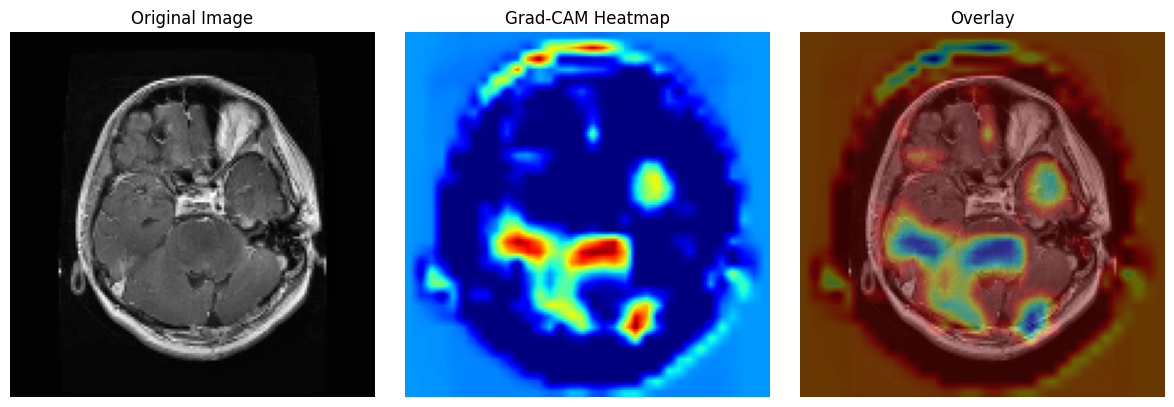

Predicted class: 0
Confidence: 0.9917


In [21]:
# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_image.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap_resized, cmap='jet')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Overlay")
plt.imshow(superimposed_img)
plt.axis('off')

plt.tight_layout()
plt.show()

# Show prediction
predicted_class = np.argmax(predictions[0])
confidence = np.max(predictions[0])
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.4f}")


### Grad-CAM Visualization and Model Prediction

The Grad-CAM visualizations provide insight into the regions of the MRI scan that the CNN model considered most important for its classification decision.

- **Original Image:** The first panel displays the input MRI scan provided to the model.
- **Grad-CAM Heatmap:** The middle panel highlights the areas with the highest model attention. Brighter (yellow/red) regions indicate where the model focused most while making its prediction.
- **Overlay:** The third panel overlays the heatmap on the original image, visually confirming that the model attended to relevant anatomical regions.

**Prediction:**  
The model predicted class **0** with a high confidence score of **0.9917**. This suggests the model is highly certain in its decision for this case.

**Interpretation:**  
The highlighted regions in the Grad-CAM overlay correspond to important features that contributed to the model’s classification. This visualization supports model transparency and provides clinicians with interpretable evidence for the automated diagnosis.


___
### Conclusion

In this project, we developed a convolutional neural network (CNN) for multi-class brain tumor classification using MRI images. The workflow included comprehensive data preprocessing with CLAHE for enhanced contrast, robust model training, and thorough evaluation through accuracy/loss curves, confusion matrix, and a classification report. To further improve model transparency, we implemented Grad-CAM, which provided visual explanations of the regions in the images that contributed most to the model's predictions.

**Key Achievements:**
- Successfully classified MRI scans into four categories: glioma, meningioma, pituitary, and no tumor, with high accuracy (over 93% on the validation set).
- Demonstrated strong generalization and minimal overfitting, as shown by close alignment of training and validation metrics.
- Applied Grad-CAM to visually interpret model predictions, enhancing the explainability of the deep learning workflow.

**What Worked Well:**
- Use of CLAHE and normalization significantly improved image quality for model training.
- The model architecture and regularization (Dropout) led to stable learning and robust performance.
- Clear, step-by-step code and markdown explanations ensured reproducibility and transparency.

**Future Improvements:**
- Explore additional data augmentation techniques to further improve model robustness.
- Investigate advanced architectures (e.g., transfer learning with pretrained models) for potentially higher accuracy.
- Increase the size and diversity of the dataset to enhance model generalizability, especially for underrepresented tumor types.
- Integrate further interpretability tools to build clinician trust in automated diagnoses.

Overall, this project demonstrates a complete deep learning pipeline for medical image classification, balancing predictive power with interpretability for real-world clinical applications.
